# Imports

To refresh imports

In [1]:
%reload_ext autoreload
%autoreload 2

Imports

In [2]:
# -------------------------------- torch stuff ------------------------------- #
import torch
from torch.utils.data import Dataset, DataLoader


# ----------------------------------- other ---------------------------------- #
from glob import glob
# import soundfile as sf
from scipy.io import wavfile
import json
import os
from tqdm import tqdm
import sys
import wandb

# ---------------------------------- Custom ---------------------------------- #
from utils.precision_loss import show_sum_error

### Why using scipy.io instead soundfile

In [3]:
# print("soundfile converts directly to float 64")
# sf.read("../data/LibriCount/10_85b5ac.wav")[0]

In [4]:
print("wavfile concervs the original format : int16")
wavfile.read("../data/LibriCount/10_85b5ac.wav")[1]

wavfile concervs the original format : int16


array([ 3095,  3265,  4328, ..., -1835, -1613, -1282], dtype=int16)

### Format

In [5]:
F16 = torch.float16
F32 = torch.float32
F64 = torch.float64

In [6]:
show_sum_error()

Conversion Errors from int16 in range(-32768, 32768) maxed by (max is=) :
	Float 16  8.0
	Float 32  0.0
	Float 64  0.0


# Consts

In [7]:
data_dir = "../data/LibriCount"
FTYPE = F32
TRAIN_SPLIT = 0.8

# Dataset

In [8]:
class AudioCountGender(Dataset):
    def __init__(self, data_dir=data_dir, dtype = FTYPE, cache=True):
        self.sounds = glob(os.path.join(data_dir,"*.wav"))
        self.labels = glob(os.path.join(data_dir,"*.json"))
        self.dtype = dtype
        self.cache = cache
        if self.cache:
            self.data = []
            for index in range(len(self.sounds)):
                sample_rate, clip = wavfile.read(self.sounds[index])
                with open(self.labels[index]) as f:
                    label = json.load(f)
                genders = [0, 0] #[Male, Female]
                for person in label:
                    gender = person["sex"]
                    if gender == "F":
                        genders[1] += 1
                    else :
                        genders[0] += 1
                self.data.append([torch.tensor(clip, dtype=self.dtype).unsqueeze(0), torch.tensor(genders, dtype=self.dtype)]) #unsqueeze serves for channel = 1
                
                
    def __getitem__(self, index):
        if self.cache:
            return self.data[index]
        else:
            # clip, sample_rate = sf.read(self.sounds[index])
            sample_rate, clip = wavfile.read(self.sounds[index])
            with open(self.labels[index]) as f:
                label = json.load(f)
            genders = [0, 0] #[Male, Female]
            for person in label:
                gender = person["sex"]
                if gender == "F":
                    genders[1] += 1
                else :
                    genders[0] += 1
            return torch.tensor(clip, dtype=self.dtype).unsqueeze(0), torch.tensor(genders, dtype=self.dtype) #unsqueeze serves for channel = 1
    def __len__(self):
        return len(self.sounds)

In [9]:
data = AudioCountGender()
data[800]

[tensor([[ 3095.,  3265.,  4328.,  ..., -1835., -1613., -1282.]]),
 tensor([3., 7.])]

# Dataloader

In [10]:
BATCH_SIZE = 64
dataloader = DataLoader(dataset=data, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

# Measures

In [11]:
from time import time
# L = []
start = time()
for d in dataloader:
    # L.append(d)
    print(len(d[0]), end="_")
end = time()
print()
print("Duration: {:.2f}s".format(end-start))
#Energy efficient mode
#Duration: 55.97s for F16 and no caching and list appending
#Duration: 1.72s for F16 and caching and list appending
#Equilibre mode 
#Duration: 12.46s for F16 and no caching and no list appending
#Duration: 0.88s for F16 and caching andn no list appending

128_128_128_128_128_128_128_128_128_128_128_128_128_128_128_128_128_128_128_128_128_128_128_128_128_128_128_128_128_128_128_128_128_128_128_128_128_128_128_128_128_128_128_128_88_
Duration: 0.76s


# Simple model

In [12]:
# torch sequential
c_1 = 64
kernel_1 = 21
c_2 = 64
kernel_2 = 7
kernel_pool = 3

c_3 = 128
kernel_3 = 3
c_4 = 256
kernel_4 = 3
model = torch.nn.Sequential( #input size = 80000
    torch.nn.Conv1d(1, c_1, kernel_1, stride=5, dtype=FTYPE),
    torch.nn.Conv1d(c_1, c_2, kernel_2, dtype=FTYPE),
    torch.nn.ReLU(),
    torch.nn.Dropout(),
    torch.nn.MaxPool1d(kernel_pool),
    
    torch.nn.Conv1d(c_2, c_3, kernel_3, dtype=FTYPE),
    torch.nn.Conv1d(c_3, c_4, kernel_4, dtype=FTYPE),
    torch.nn.ReLU(),
    torch.nn.Dropout(),
    torch.nn.MaxPool1d(kernel_pool),
    
    torch.nn.Flatten(),
    torch.nn.Linear(c_4*1775, 2, dtype=FTYPE),
)

In [13]:
example = d[0].to("cuda")
model.to("cuda")

print("Shape : ", model.forward(example).shape)
model.forward(example)

Shape :  torch.Size([88, 2])


tensor([[ 2.2570e+02,  5.5099e+02],
        [-1.2534e+03,  1.3617e+02],
        [-4.6795e+01,  7.4459e+02],
        [-8.2248e+02,  8.5553e+02],
        [ 3.1124e+02,  3.1932e+02],
        [-5.9964e+02,  1.2370e+03],
        [-3.0364e+02,  1.5586e+02],
        [-6.4023e+02,  1.3432e+03],
        [ 5.3624e+02, -1.4660e+02],
        [-3.1876e+02, -8.3244e+01],
        [-6.2716e+02, -8.6650e+02],
        [-6.2086e+00,  9.5093e+01],
        [-3.5492e+02, -4.7577e+02],
        [-1.3043e+03, -3.5862e+02],
        [-3.1223e+02, -1.3156e+02],
        [ 1.5397e+00,  1.9312e+00],
        [ 2.8877e+02,  1.2216e+03],
        [-8.6916e+02,  1.0431e+03],
        [-5.5560e+02,  7.5136e+02],
        [-6.3094e+02,  5.6613e+02],
        [-3.3878e+00, -2.9167e+00],
        [-3.1200e-01, -1.0904e+01],
        [ 1.1385e+03,  2.6615e+02],
        [-7.8303e+02,  7.8648e+01],
        [ 4.6866e+02,  4.2235e+02],
        [-1.4756e+03, -1.0930e+03],
        [-7.7822e+01,  2.3077e+02],
        [ 3.6051e+02,  8.926

# Wandb

In [14]:
wandb.init(project="klee_project_audio", entity="mustapha")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: mustapha (use `wandb login --relogin` to force relogin)


In [15]:
LEARNING_RATE = 1e-2
EPOCHS = 700
OPTIMIZER_L2 = 0.01
OPTIMIZER_MOM = 0.9
SCHEDULER_PATIENCE = 10
SCHEDULER_FACTOR = 0.5
SCHEDULER_MIN_LR = 1e-6
CLIP_GRAD = 1e5


wandb.config.update({
    "learning_rate": LEARNING_RATE,
    "epochs": EPOCHS,
    "OPTIMIZER": "SGD",
    "OPTIMIZER_L2":OPTIMIZER_L2,
    "OPTIMIZER_MOM": OPTIMIZER_MOM,
    "batch_size": BATCH_SIZE,
    "SCHEDULER": "ReduceLROnPlateau",
    "SCHEDULER_PATIENCE": SCHEDULER_PATIENCE,
    "SCHEDULER_FACTOR": SCHEDULER_FACTOR,
    "SCHEDULER_MIN_LR": SCHEDULER_MIN_LR,
    "CLIP_GRAD": CLIP_GRAD,
})

# Simple train

In [ ]:
loss = torch.nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, weight_decay=OPTIMIZER_L2, momentum=OPTIMIZER_MOM)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=SCHEDULER_PATIENCE, factor=SCHEDULER_FACTOR,min_lr=SCHEDULER_MIN_LR)

model.to("cuda")

for epoch in range(EPOCHS):
    mean_loss = 0
    for d in tqdm(dataloader):
        audios = d[0].to("cuda")
        labels = d[1].to("cuda")
        predictions = model.forward(audios)
        loss_value = loss(predictions, labels)
        mean_loss += loss_value.item()
        optimizer.zero_grad()
        loss_value.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), -CLIP_GRAD, CLIP_GRAD)
        optimizer.step()
    scheduler.step(mean_loss/len(dataloader))
    print("Epoch {}/{}".format(epoch+1, EPOCHS))
    print("Train Loss : {:.4f}".format(mean_loss/len(dataloader)))
    wandb.log({"loss":mean_loss/len(dataloader), "epoch":epoch, "next_lr" :scheduler.state_dict()["_last_lr"][0]})
    # wandb.watch(model)

# FFT Dataset

In [10]:
import librosa
import librosa.display
import scipy
import numpy as np

import matplotlib.pyplot as plt
from time import time

Pay attention, librosa's mfcc is about 20-30 times slower than scipy's signal.spectrogram ! Just keep that in mind. 1 MFCC takes about 0.02s on my machine for a 5 seconds (80000 sample) audio.

In addition :

    Even though MFCCs are used in related tasks and are included in our baseline evaluations, they are
    known to perform poorly when used in CNNs [70]. This is why we decided to not to use the MFCCs
    as an input for the proposed architectures. The remaining input representations are identical to those
    listed in [76]:

Quoting from the original paper of CountNet.

In [11]:
clip, label = data[1500]
label

tensor([0., 1.])

MFCC

total_time : 1.77s
MFCC shape :  (100, 157)


/tmp/ipykernel_13937/1015913920.py:10: RuntimeWarning: invalid value encountered in log
  librosa.display.specshow(np.log(mfcc), y_axis="mel", x_axis='s', sr=16000)


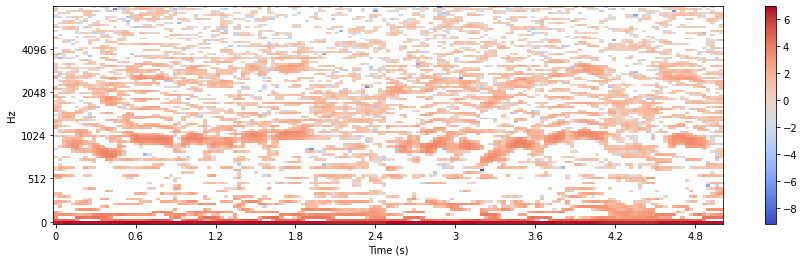

In [81]:
tik = time()
for _ in range(100):
    mfcc = librosa.feature.mfcc(y=clip[0].numpy(), n_mfcc=100, sr=16000)
tok = time()
print("total_time : {:.2f}s".format(tok-tik))
print("MFCC shape : ", mfcc.shape)

plt.figure(figsize=(15, 4))
# librosa.display.specshow(mfcc, x_axis='time', sr=16000)
librosa.display.specshow(np.log(mfcc), y_axis="mel", x_axis='s', sr=16000)
plt.colorbar()
plt.show()

Scipy FFT

In [242]:
A = torch.tensor(clip[0].numpy(), dtype=F64).numpy()
A 

array([ 329.,  333.,  369., ...,  -72.,   21., -170.])

total_time : 0.08s
FFT shape :  (129, 357)


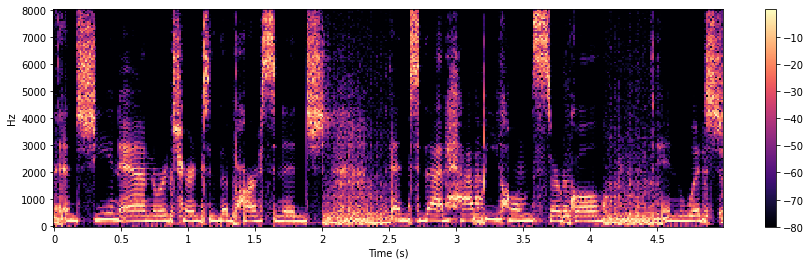

In [250]:
tik = time()
for _ in range(100):
    _, _, fft = scipy.signal.spectrogram(clip[0].numpy(), fs=16000, nperseg=256, noverlap=32)
tok = time()
print("total_time : {:.2f}s".format(tok-tik))
print("FFT shape : ", fft.shape)

# fft = np.log(fft)
fft /= np.linalg.norm(fft, axis=0, keepdims=True) # normalize by sample with l2 norm
plt.figure(figsize=(15, 4))
librosa.display.specshow(librosa.amplitude_to_db(fft, ref=np.max), y_axis="hz", x_axis='s', sr=16000, hop_length=224)
plt.colorbar()
plt.show()

Librosa FFT

stft stands for short time Fourier transform. which means a sliding window is used to compute the spectrogram. Exactly as scipy.signal.spectrogram with a `hann` window, except that the window is 2048 and slides for 2048//4 samples.

total_time : 0.97s
S shape (freqs, window fft) :  (129, 358)


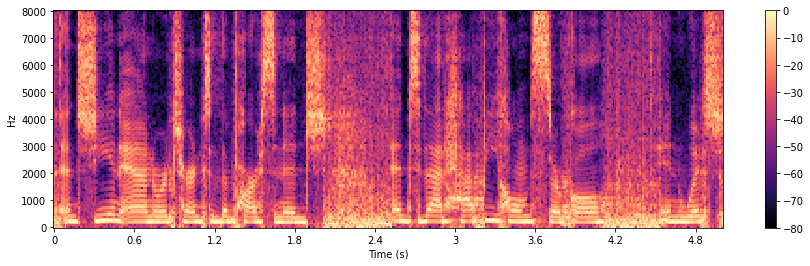

In [213]:
tik = time()
for _ in range(100):
    S = np.abs(librosa.stft(y=clip[0].numpy(), n_fft=256, hop_length=224))
tok = time()
print("total_time : {:.2f}s".format(tok-tik))

S /= np.linalg.norm(S, axis=0, keepdims=True) # normalize by sample with l2 norm
print("S shape (freqs, window fft) : ", S.shape)
plt.figure(figsize=(15, 4))
librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max), y_axis="hz", x_axis='s', sr=16000, hop_length=224) #amplitude_to_db is li np.log
# librosa.display.specshow(np.log(S),  y_axis="hz",x_axis='s', sr=16000)
plt.colorbar()
plt.show()

In [208]:
data.sounds[0]

'../data/LibriCount/0_005682.wav'

In [ ]:
wavfile.read()